# Modeling and Simulation in Python

Richard Gao


In [3]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

In [4]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [5]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x = r_0,
             y = 0 * m,
             vx = 0 * m / s,
             vy = -30330 * m / s)

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,-30330.0 meter / second


In [6]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1 * UNITS.year)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,1 year


In [7]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    displacement = Vector(x, y)
    
    force = G * m1 * m2 / displacement.mag**2

    return displacement.hat() * force 

In [8]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [9]:
# The slope function

def slope_func(state, t, system):
    x, y, vx, vy = state
    unpack(system)    

    force = -universal_gravitation(state, system)
    
    dvxdt = force.x / m2
    dvydt = force.y / m2
    
    return vx, vy, dvxdt, dvydt

In [10]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [11]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,152
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [12]:
results.tail()

,x,y,vx,vy
1.733120e+07,-1.415448e+11,4.722822e+10,9936.205828,27953.740657
2.191359e+07,-4.593225e+10,1.386638e+11,28915.537326,8728.023125
2.670787e+07,9.130711e+10,1.096478e+11,23148.466280,-20175.414008
3.086498e+07,1.406544e+11,-4.491126e+09,-1262.139959,-31009.057667
3.155693e+07,1.381817e+11,-2.581481e+10,-5874.012782,-30507.610893


In [13]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(31556925.9747, 'second')>

In [14]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(365.24219878124995, 'day')>

In [22]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, t_eval=ts, method='RK23')

In [23]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [24]:
# Scaling the distance to million km

x = results.x / 1e9;
y = results.y / 1e9;

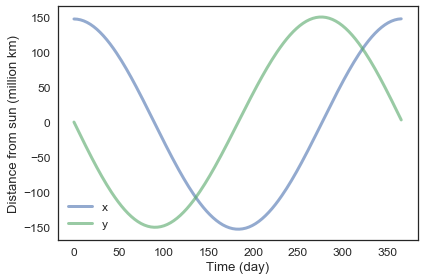

In [25]:
plot(x, label='x')
plot(y, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

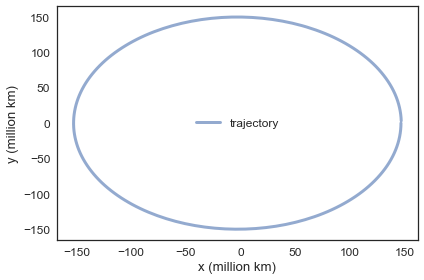

In [26]:
# And plotting

plot(x, y, label='trajectory')

decorate(xlabel='x (million km)',
         ylabel='y (million km)')

In [20]:
help(run_ode_solver)

Help on function run_ode_solver in module modsim:

run_ode_solver(system, slope_func, **options)
    Computes a numerical solution to a differential equation.
    
    `system` must contain `init` with initial conditions,
    `t_0` with the start time, and `t_end` with the end time.
    
    It can contain any other parameters required by the slope function.
    
    `options` can be any legal options of `scipy.integrate.solve_ivp`
    
    system: System object
    slope_func: function that computes slopes
    
    returns: TimeFrame

